Mod from v2 adding variational output

In [1]:
AEversion = '3'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Sun Jul  7 20:49:01 2019
[0] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[1] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[2] GeForce GTX 1080 | 25'C,   0 % |     0 /  8119 MB |
[3] GeForce GTX 1080 | 21'C,   0 % |     1 /  8119 MB |
[4] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190702_50part_PtOrder_v1/{}.npy', N_part=20, N_features=5)

In [9]:
dataset.loadTrainSM(N_train_max=2e6)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
QCD is limiting, using it for both val and split
Expected 1.69M train
Expected 1.69M val

Loading Wlnu
Reloading QCD for validation
Loading Zll
Loading ttbar
+--------+----------+-------+-------+
| Sample | Evts tot | Train |  Val  |
+--------+----------+-------+-------+
|  Wlnu  |  2000k   | 1000k | 1000k |
|  qcd   |   690k   |  571k |  571k |
|  Zll   |  1000k   |  113k |  113k |
| ttbar  |  1000k   |   5k  |   5k  |
+--------+----------+-------+-------+
Tot training 1.69 M
Tot val 1.69 M


In [10]:
dataset.loadValidationSamples('BSM')

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (500.0k)
Loading hChToTauNu (338.5k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p+3)*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p+3)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        sig_pt = 1. + 1e-6 + F.elu(x_raw[:,:,1]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,2], min_val=-5, max_val=5).view(-1, self.No, 1)
        sig_eta = 1. + 1e-6 + F.elu(x_raw[:,:,3]).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,4]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        sig_phi = 1. + 1e-6 + F.elu(x_raw[:,:,5]).view(-1, self.No, 1)
        # charge
        charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 3)
        # pId
        pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,6:].view(-1,2)), dim=1).view(-1, self.No, 5)
        
        x = torch.cat((pt, eta, phi, sig_pt, sig_eta, sig_phi, charge_cat, pId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [12]:
Latent_dimension = int(2*dataset.inputs.shape[1])
Hidden_dimension = int(0.5*(Latent_dimension + dataset.inputs.shape[1]*dataset.inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=40, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=40, out_features=70, bias=True)
      (1): ReLU()
      (2): Linear(in_features=70, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=160, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 34124


In [13]:
model.useGPU(0)

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Sun Jul  7 20:49:18 2019
[0] GeForce GTX 1080 | 25'C,   3 % |   468 /  8119 MB | ocerri(457M)
[1] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 25'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 21'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |


## Loss

In [14]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    out_gauss = torch.pow((x_in[:,:,:3] - x_out[:,:,:3])/ x_out[:,:,3:6], 2) + torch.log(x_out[:,:,3:6])
    out = torch.sum(out_gauss, dim=2)
    
    #Cat cross entropy charge
    aux = torch.log(x_out[:,:,6:9]).view(-1, 3)
    aux = F.nll_loss(aux, 1+x_in[:,:,3].view(-1).long(), reduction='none')
    out += aux.view(-1, x_in.shape[1])
    
    #Cat cross entropy pId
    aux = torch.log(x_out[:,:,9:14]).view(-1, 5)
    out += F.nll_loss(aux, x_in[:,:,4].view(-1).long(), reduction='none').view(-1, x_in.shape[1])
    
    out_per_evt = torch.sum(out, dim=1)
    
    if reduction == 'mean':
        return torch.mean(out_per_evt)
    elif reduction == 'none':
        return out_per_evt
    else:
        raise

## Training

In [15]:
training_params = {'batch_size': 10000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 500

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [16]:
# torch.autograd.set_detect_anomaly(True);

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [18]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': []}
optimizer.zero_grad()
for epoch in range(max_epochs):
    batch_loss = []
    
    #### ---- Training ---- ####
    model.train()
    dataset.charge(dataset.SMMix_train)
    train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
    pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        
        x_prime = model(local_x)        
        loss = criterion(local_x, x_prime)
        if np.isnan(loss.item()) or np.isinf(loss.item()):
            print('Invalid loss!!!')
            raise
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(loss_history['train']) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    aux_loss = 0
    N_batches = 0
    for local_x, _ in train_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        aux_loss += loss.item()
        N_batches += 1
    batch_loss.append(aux_loss/N_batches)
    if epoch > 0:
        if batch_loss[-1] < np.min(np.array(loss_history['train'])[:,-1]):
            print('[INFO]: Saving best model')
            torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')
    
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(loss_history['train']) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
    if len(loss_history['train']) > 1:
        d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout)
    
    loss_history['train'].append(batch_loss)
    
    #### ---- Validation ---- ####
    dataset.charge(dataset.SMMix_val)
    val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    aux_loss = 0
    N_batches = 0
    for local_x, _ in val_data_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime)
        if np.isnan(loss.item()) or np.isinf(loss.item()):
            print('Invalid loss!!!')
            raise
        aux_loss += loss.item()
        N_batches += 1
    loss_history['val'].append(aux_loss/N_batches)
    printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
    print(printout)
    
    print('')
    if not earlyStopping.check(loss_history['val'][-1]):
        break

    scheduler.step(batch_loss[-1])
    
    #### ---- Anomaly Detection monitor ---- ####
    if epoch%3 == 0:
        print('------------ Anomaly Detection monitor ------------')
        BSM_eff['ep'].append(epoch)
        dataset.loss['SMMix'] = np.zeros((0))
        
        pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
        for i, (local_x, _) in enumerate(val_data_iter):
                pb.show(i)
                if model.onGPU:
                    local_x = local_x.cuda(model.N_GPU)
                    
                x_prime = model(local_x)
                loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))
        
        p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
        if not 'p_SM' in BSM_eff.keys():
            BSM_eff['p_SM'] = p_SM
        q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)
        
        table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))
        
        for n in dataset.BSM_names:
            dataset.loss[n] = np.zeros((0))

            dataset.charge(dataset.valSamples[n])
            data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
            pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
            for i, (local_x, _) in enumerate(data_iter):
                pb.show(i)
                if model.onGPU:
                    local_x = local_x.cuda(model.N_GPU)

                x_prime = model(local_x)
                loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                dataset.loss[n] = np.concatenate((dataset.loss[n], loss))
        
            out = dataset.loss[n] > np.atleast_2d(q_SM).T
            p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
            BSM_eff[n].append(p_BSM)
            
            table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
        print(table)                
        print('---------------------------------------------------\n\n')

model.eval()
torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');

Epoch 0: [####################]  100% - Tot. time: 6.7 s            
Loss: 7.81e+01
Val Loss: 7.82e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.7 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.2 s
hChToTauNu: [####################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 8.59e-04 | 1.64e-02 |
| leptoquark | 3.65e-05 | 9.21e-04 | 1.44e-02 |
| hToTauTau  | 3.48e-04 | 4.41e-03 | 3.67e-02 |
| hChToTauNu | 8.42e-04 | 9.35e-03 | 5.90e-02 |
+------------+----------+----------+----------+
-------------------------------------------


Epoch 1: [####################]  100% - Tot. time: 6.6 s                        
Loss: 6.37e+01 - Delta: -1.45e+01
Val Loss: 6.37e+01

Epoch 2: [##

Val Loss: 3.83e+01

Epoch 20: [####################]  100% - Tot. time: 6.8 s                        
Loss: 3.07e+01 - Delta: -7.66e+00 - Trend: -1.49e+01
Val Loss: 3.07e+01

Epoch 21: [####################]  100% - Tot. time: 6.7 s                        
Loss: 3.01e+01 - Delta: -5.42e-01 - Trend: 7.12e+00
Val Loss: 3.01e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 9.2 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.1 s
hChToTauNu: [####################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.29e-05 | 1.40e-03 | 3.04e-02 |
| leptoquark | 5.85e-05 | 1.02e-03 | 1.30e-02 |
| hToTauTau  | 1.70e-04 | 2.25e-03 | 2.52e-02 |
| hChToTauNu | 3.78e-04 | 3.96e-03 | 3.91e-02 |
+------------+--

Epoch 40: [####################]  100% - Tot. time: 6.7 s                        
Loss: 1.91e+01 - Delta: -8.63e-01 - Trend: 2.45e+00
Val Loss: 1.91e+01

Epoch 41: [####################]  100% - Tot. time: 6.7 s                        
Loss: 1.93e+01 - Delta: 2.90e-01 - Trend: 1.15e+00
Val Loss: 1.94e+01

Epoch 42: [####################]  100% - Tot. time: 6.7 s                        
Loss: 1.96e+01 - Delta: 2.66e-01 - Trend: -2.42e-02
Val Loss: 1.96e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.8 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.5 s
hChToTauNu: [####################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 6.29e-05 | 1.24e-03 | 3.93e-02 |
| leptoquark | 1.24e-04 | 1.

Epoch 61: [####################]  100% - Tot. time: 6.7 s                       
Loss: 1.60e+01 - Delta: 6.79e-01 - Trend: 6.99e-01
Val Loss: 1.60e+01

Epoch 62: [####################]  100% - Tot. time: 6.7 s                        
Loss: 3.98e+01 - Delta: 2.38e+01 - Trend: 2.31e+01
Val Loss: 3.98e+01

Epoch 63: [####################]  100% - Tot. time: 6.8 s                        
Loss: 1.43e+01 - Delta: -2.55e+01 - Trend: -4.93e+01
Val Loss: 1.43e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.8 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.0 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 8.38e-04 | 3.43e-02 |
| leptoquark | 1.46e-05 | 6.9

Epoch 82: [####################]  100% - Tot. time: 6.7 s                        
Loss: 9.32e+00 - Delta: -7.22e-01 - Trend: -2.42e-01
Val Loss: 9.35e+00

Epoch 83: [####################]  100% - Tot. time: 6.7 s                        
Loss: 8.87e+00 - Delta: -4.49e-01 - Trend: 2.72e-01
Val Loss: 8.91e+00

Epoch 84: [####################]  100% - Tot. time: 6.8 s                        
Loss: 1.04e+01 - Delta: 1.50e+00 - Trend: 1.95e+00
Val Loss: 1.04e+01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.7 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.3 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 4.19e-04 | 2.41e-02 |
| leptoquark | 0.00e+00 | 4

Epoch 103: [####################]  100% - Tot. time: 7.0 s                        
Loss: 6.40e+00 - Delta: -2.04e-01 - Trend: -1.18e-03
Val Loss: 6.48e+00

Epoch 104: [####################]  100% - Tot. time: 6.8 s                        
Loss: 6.31e+00 - Delta: -9.29e-02 - Trend: 1.11e-01
Val Loss: 6.39e+00

Epoch 105: [####################]  100% - Tot. time: 6.8 s                        
Loss: 6.12e+00 - Delta: -1.89e-01 - Trend: -9.57e-02
Val Loss: 6.20e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.0 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 2.93e-04 | 1.76e-02 |
| leptoquark | 0.00e+0

Epoch 124: [####################]  100% - Tot. time: 6.7 s                        
Loss: 4.68e+00 - Delta: -2.77e-02 - Trend: 1.82e-02
Val Loss: 4.81e+00

Epoch   124: reducing learning rate of group 0 to 8.1000e-06.
Epoch 125: [####################]  100% - Tot. time: 6.8 s                        
Loss: 4.27e+00 - Delta: -4.14e-01 - Trend: -3.86e-01
Val Loss: 4.41e+00

Epoch 126: [####################]  100% - Tot. time: 6.8 s                        
Loss: 4.22e+00 - Delta: -4.91e-02 - Trend: 3.65e-01
Val Loss: 4.36e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 9.0 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l

Epoch 145: [####################]  100% - Tot. time: 6.8 s                        
Loss: 3.48e+00 - Delta: -7.89e-02 - Trend: 7.33e-02
Val Loss: 3.68e+00

Epoch 146: [####################]  100% - Tot. time: 6.8 s                        
Loss: 3.42e+00 - Delta: -5.52e-02 - Trend: 2.36e-02
Val Loss: 3.63e+00

Epoch 147: [####################]  100% - Tot. time: 6.7 s                        
Loss: 3.49e+00 - Delta: 6.56e-02 - Trend: 1.21e-01
Val Loss: 3.69e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.3 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.35e-04 | 1.29e-02 |
| leptoquark | 0.00e+00 |

Epoch 166: [####################]  100% - Tot. time: 6.7 s                        
Loss: 2.77e+00 - Delta: -6.29e-02 - Trend: 1.02e-01
Val Loss: 3.00e+00

Epoch 167: [####################]  100% - Tot. time: 6.8 s                        
Loss: 2.66e+00 - Delta: -1.12e-01 - Trend: -4.88e-02
Val Loss: 2.89e+00

Epoch 168: [####################]  100% - Tot. time: 6.7 s                        
Loss: 2.61e+00 - Delta: -4.28e-02 - Trend: 6.89e-02
Val Loss: 2.85e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.6 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.56e-04 | 1.34e-02 |
| leptoquark | 0.00e+00

Epoch 187: [####################]  100% - Tot. time: 6.8 s                        
Loss: 2.26e+00 - Delta: 2.43e-01 - Trend: 3.64e-01
Val Loss: 2.53e+00

Epoch 188: [####################]  100% - Tot. time: 6.9 s                        
Loss: 2.03e+00 - Delta: -2.26e-01 - Trend: -4.69e-01
Val Loss: 2.30e+00

Epoch 189: [####################]  100% - Tot. time: 6.8 s                        
Loss: 1.92e+00 - Delta: -1.09e-01 - Trend: 1.17e-01
Val Loss: 2.20e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.4 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.1 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.56e-04 | 1.35e-02 |
| leptoquark | 0.00e+00 

Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.1 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.5 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 0.00e+00 | 3.56e-04 | 1.34e-02 |
| leptoquark | 0.00e+00 | 2.92e-05 | 2.16e-03 |
| hToTauTau  | 2.00e-06 | 6.20e-05 | 2.75e-03 |
| hChToTauNu | 1.18e-05 | 8.57e-05 | 4.50e-03 |
+------------+----------+----------+----------+
-------------------------------------------


Epoch 214: [####################]  100% - Tot. time: 7.5 s                        
Loss: 1.68e+00 - Delta: -1.10e+00 - Trend: -2.43e+00
Val Loss: 2.00e+00

Epoch 215: [####################]  100% - Tot. time: 7.5 s                        
Loss: 1.33e+00 - Delta: -3.52e-01 - Trend: 7.52e-01
Val Loss: 1.64e+00

Epoch 216: [####################]  100% 

Epoch 233: [####################]  100% - Tot. time: 7.6 s                        
Loss: 9.49e-01 - Delta: -1.43e-02 - Trend: -5.74e-03
Val Loss: 1.31e+00

Epoch 234: [####################]  100% - Tot. time: 7.5 s                        
Loss: 9.54e-01 - Delta: 5.45e-03 - Trend: 1.98e-02
Val Loss: 1.31e+00

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 9.8 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.2 s
hToTauTau: [####################]  100% - Tot. time: 2.6 s
hChToTauNu: [####################]  100% - Tot. time: 1.5 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 3.77e-04 | 1.38e-02 |
| leptoquark | 0.00e+00 | 2.92e-05 | 2.11e-03 |
| hToTauTau  | 2.00e-06 | 6.20e-05 | 2.65e-03 |
| hChToTauNu | 1.18e-05 | 8.57e-05 | 4.26e-03 |
+------------+----------+----------

Epoch 256: [####################]  100% - Tot. time: 7.4 s                        
Loss: 6.69e-01 - Delta: 1.12e-02 - Trend: -8.05e-04
Val Loss: 1.06e+00

Epoch 257: [####################]  100% - Tot. time: 7.5 s                        
Loss: 6.61e-01 - Delta: -7.48e-03 - Trend: -1.87e-02
Val Loss: 1.05e+00

Epoch 258: [####################]  100% - Tot. time: 7.6 s                         
Loss: 5.91e-01 - Delta: -6.98e-02 - Trend: -6.23e-02
Val Loss: 9.83e-01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 10.3 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.1 s
hToTauTau: [####################]  100% - Tot. time: 2.6 s
hChToTauNu: [####################]  100% - Tot. time: 1.5 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 3.56e-04 | 1.37e-02 |
| leptoquark | 0.00e

Epoch 277: [####################]  100% - Tot. time: 6.8 s                         
Loss: 3.62e-01 - Delta: -6.23e-02 - Trend: -6.91e-02
Val Loss: 7.79e-01

Epoch 278: [####################]  100% - Tot. time: 6.7 s                         
Loss: 3.52e-01 - Delta: -1.03e-02 - Trend: 5.20e-02
Val Loss: 7.69e-01

Epoch 279: [####################]  100% - Tot. time: 6.8 s                         
Loss: 4.03e-01 - Delta: 5.11e-02 - Trend: 6.13e-02
Val Loss: 8.23e-01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.9 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.1 s
hToTauTau: [####################]  100% - Tot. time: 2.1 s
hChToTauNu: [####################]  100% - Tot. time: 1.4 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 3.77e-04 | 1.38e-02 |
| leptoquark | 0.00e+

hToTauTau: [####################]  100% - Tot. time: 1.9 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 4.19e-05 | 3.98e-04 | 1.39e-02 |
| leptoquark | 0.00e+00 | 3.65e-05 | 2.30e-03 |
| hToTauTau  | 4.00e-06 | 6.80e-05 | 2.91e-03 |
| hChToTauNu | 8.86e-06 | 9.75e-05 | 4.64e-03 |
+------------+----------+----------+----------+
-------------------------------------------


Epoch 388: [####################]  100% - Tot. time: 6.7 s                         
Loss: -4.86e-01 - Delta: 6.20e-04 - Trend: 1.63e-02
Val Loss: 1.97e-02

Epoch 389: [####################]  100% - Tot. time: 6.9 s                         
Loss: -4.92e-01 - Delta: -6.47e-03 - Trend: -7.09e-03
Val Loss: 1.41e-02

Epoch 390: [####################]  100% - Tot. time: 6.8 s                         
Loss: -4.93e-01 - Delta: -4.85e-04 - Trend: 5.99e-03


Epoch 408: [####################]  100% - Tot. time: 7.0 s                         
Loss: -6.20e-01 - Delta: -7.43e-03 - Trend: 1.82e-03
Val Loss: -9.84e-02

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 9.1 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.2 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 3.98e-04 | 1.40e-02 |
| leptoquark | 0.00e+00 | 3.65e-05 | 2.36e-03 |
| hToTauTau  | 4.00e-06 | 6.80e-05 | 2.99e-03 |
| hChToTauNu | 8.86e-06 | 9.75e-05 | 4.72e-03 |
+------------+----------+----------+----------+
-------------------------------------------


Epoch 409: [####################]  100% - Tot. time: 6.8 s                         
Loss: -6.

Epoch 427: [####################]  100% - Tot. time: 6.8 s                         
Loss: -7.39e-01 - Delta: -1.16e-02 - Trend: 6.44e-03
Val Loss: -2.01e-01

Epoch 428: [####################]  100% - Tot. time: 6.8 s                         
Loss: -7.39e-01 - Delta: 1.64e-05 - Trend: 1.17e-02
Val Loss: -2.00e-01

Epoch 429: [####################]  100% - Tot. time: 6.8 s                         
Loss: -7.33e-01 - Delta: 5.27e-03 - Trend: 5.25e-03
Val Loss: -1.95e-01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.6 s
Ato4l: [#####]  100% - Tot. time: 0.1 s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: -1.01e+00 - Delta: -4.52e-02 - Trend: -6.96e-02
Val Loss: -4.34e-01

Epoch 473: [####################]  100% - Tot. time: 6.8 s                         
Epoch 476: [####################]  100% - Tot. time: 6.9 s                         
Loss: -1.03e+00 - Delta: -3.11e-03 - Trend: 3.36e-03
Val Loss: -4.48e-01

Epoch 477: [####################]  100% - Tot. time: 6.9 s                         
Loss: -1.04e+00 - Delta: -1.13e-02 - Trend: -8.16e-03
Val Loss: -4.58e-01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 8.4 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.0 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 3.98e-04 | 1.45e-02 |
| leptoquark 

Epoch 496: [####################]  100% - Tot. time: 6.8 s                         
Loss: -1.14e+00 - Delta: -2.12e-03 - Trend: 2.13e-03
Val Loss: -5.46e-01

Epoch 497: [####################]  100% - Tot. time: 6.8 s                         
Loss: -1.14e+00 - Delta: -2.85e-03 - Trend: -7.31e-04
Val Loss: -5.48e-01

Epoch 498: [####################]  100% - Tot. time: 6.8 s                         
Loss: -1.15e+00 - Delta: -1.00e-02 - Trend: -7.20e-03
Val Loss: -5.56e-01

-------- Anomaly Detection monitor --------
SM Mix: [####################]  100% - Tot. time: 9.2 s
Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.0 s
hToTauTau: [####################]  100% - Tot. time: 2.4 s
hChToTauNu: [####################]  100% - Tot. time: 1.3 s
+------------+----------+----------+----------+
|   SM Mix   | 1.00e-05 | 1.00e-04 | 1.00e-03 |
+------------+----------+----------+----------+
|   Ato4l    | 2.10e-05 | 3.77e-04 | 1.44e-02 |
| leptoquark 

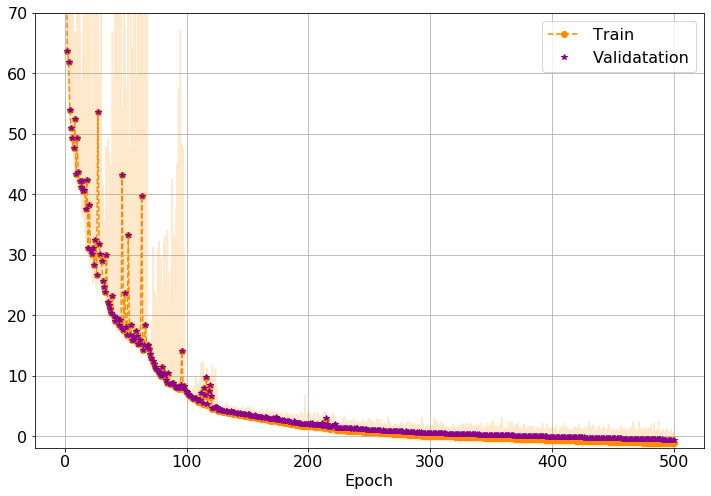

In [32]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(0.9*np.min(train_loss_flat), 1.1*np.max(loss_history['train'][1:, -1]))

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

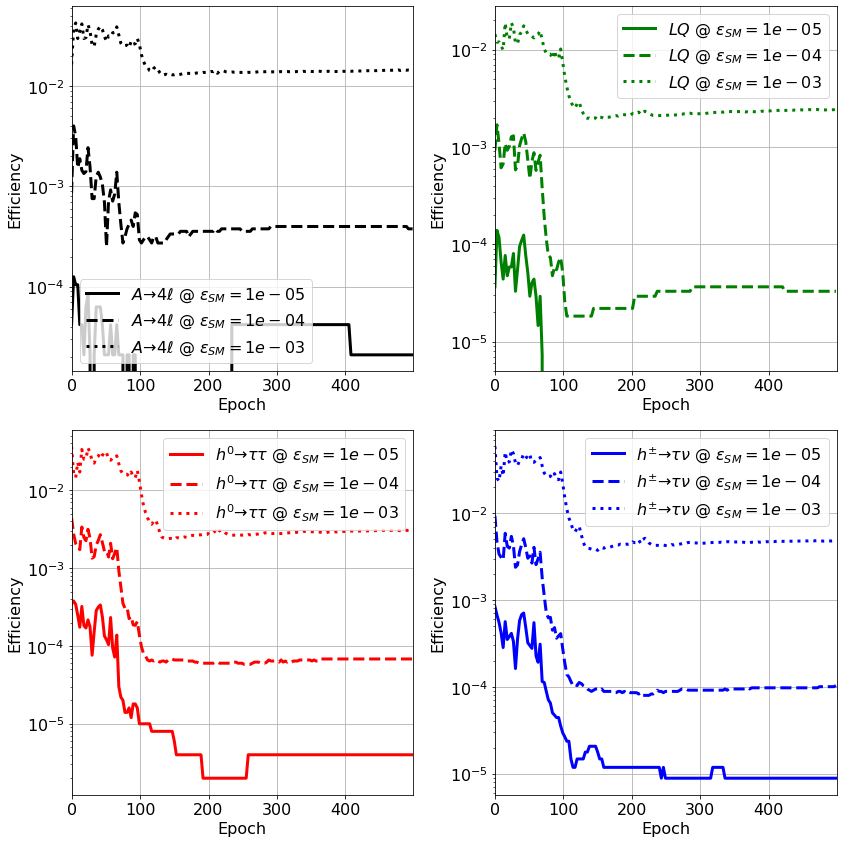

In [22]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

# Convergence check

In [34]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/nfshome/ocerri/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


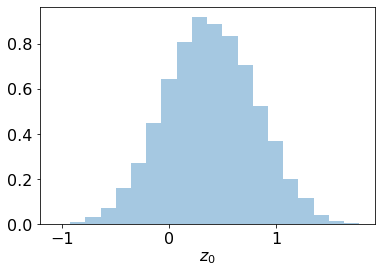

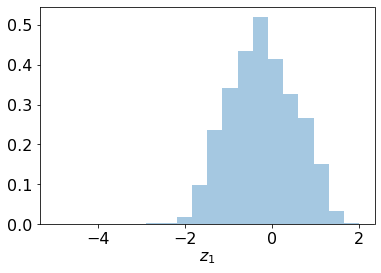

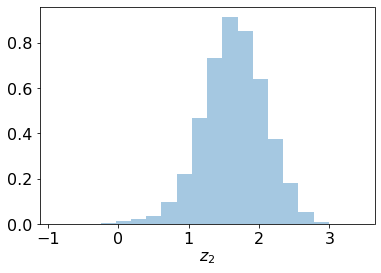

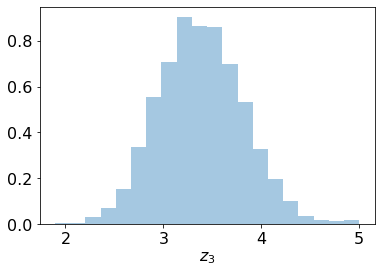

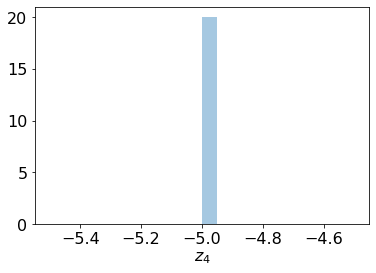

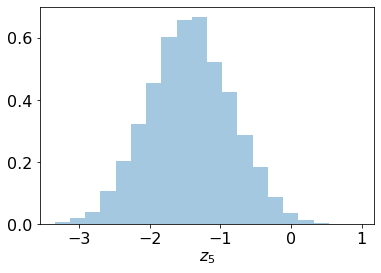

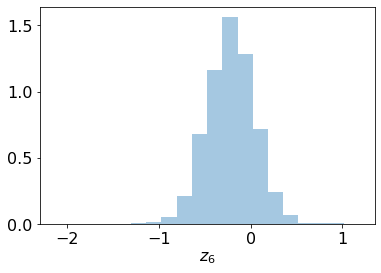

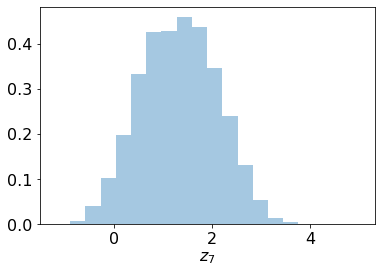

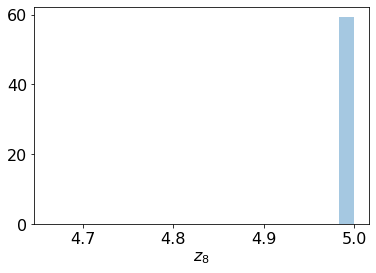

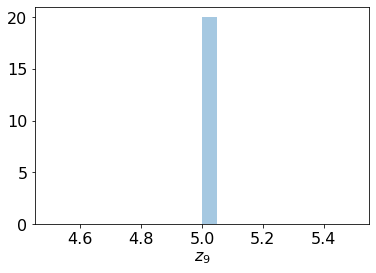

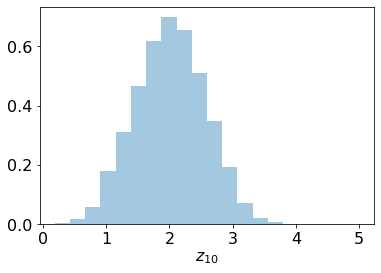

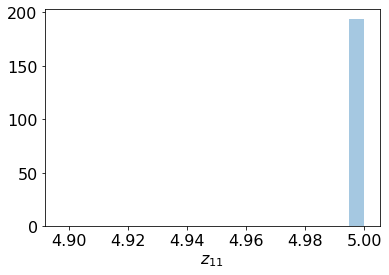

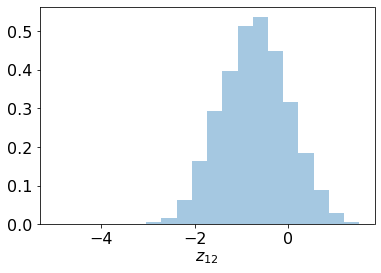

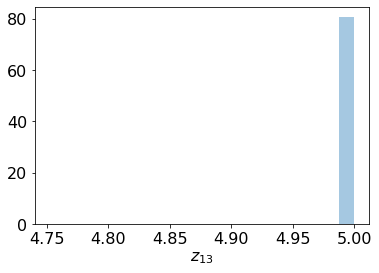

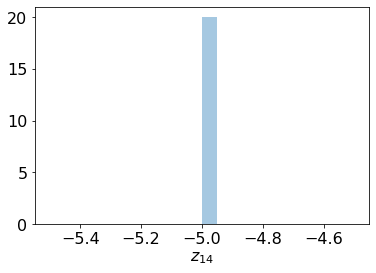

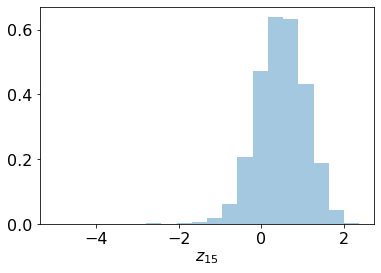

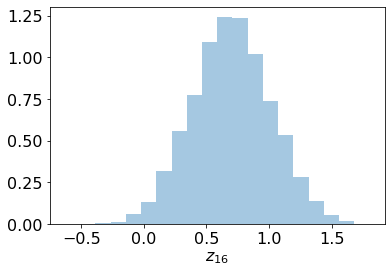

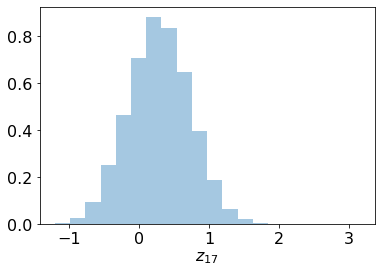

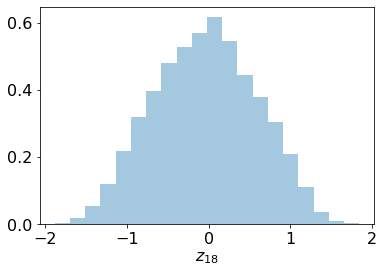

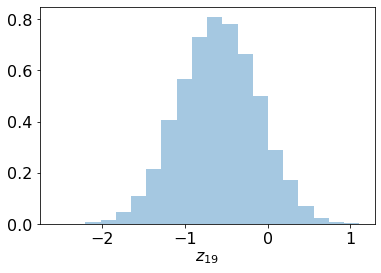

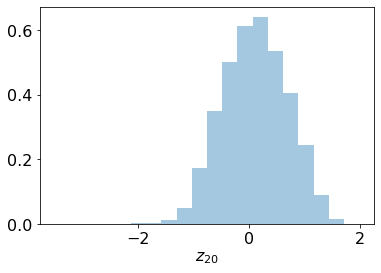

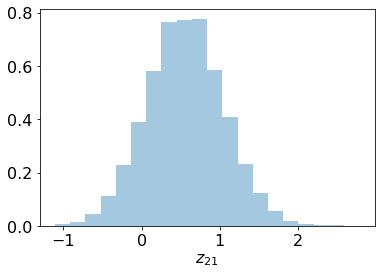

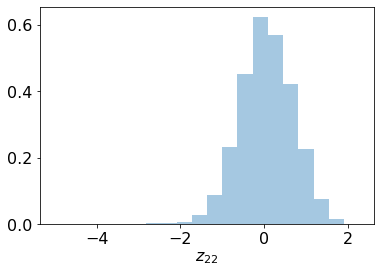

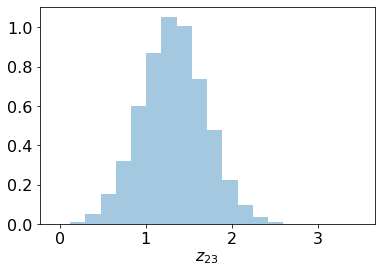

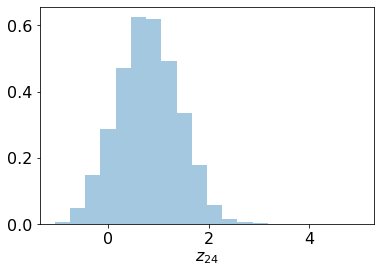

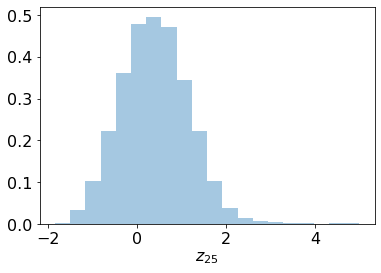

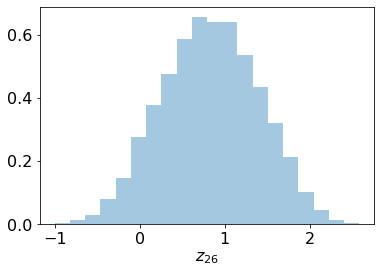

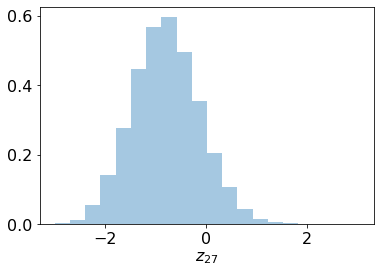

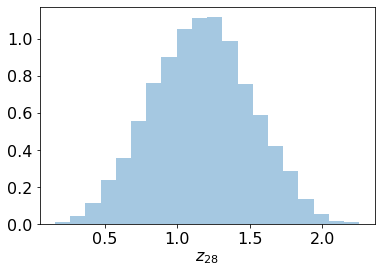

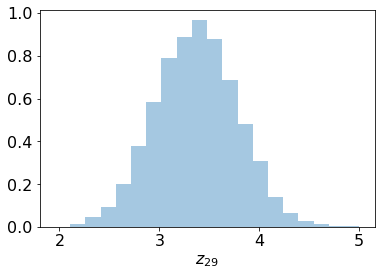

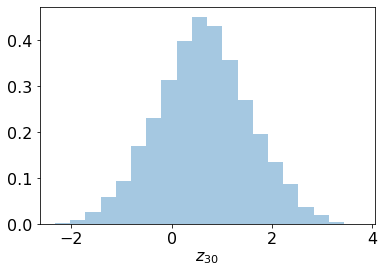

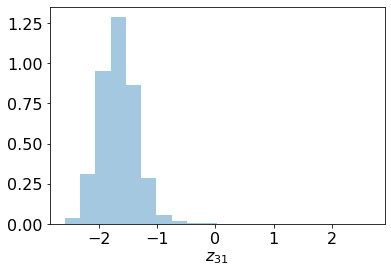

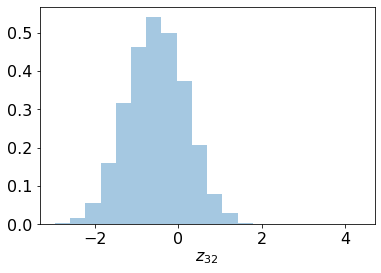

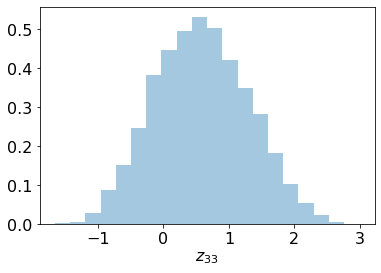

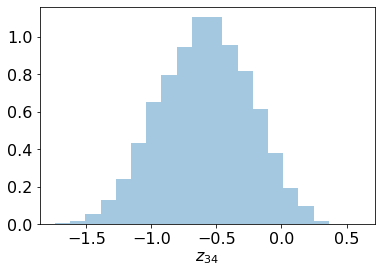

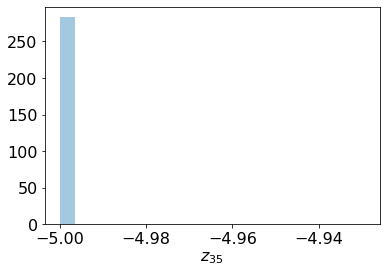

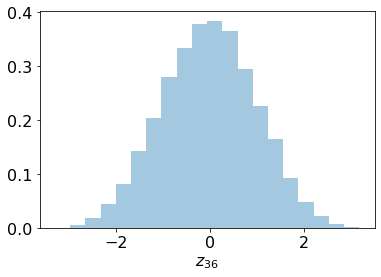

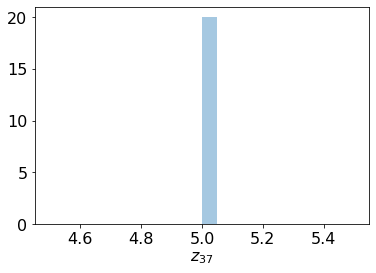

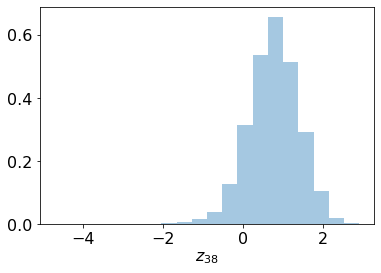

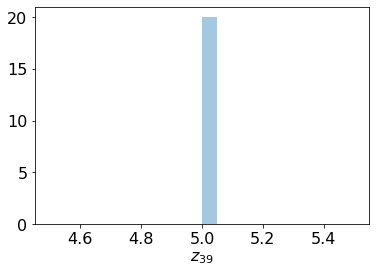

In [24]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

0
1
2
3
(10000, 20)
4


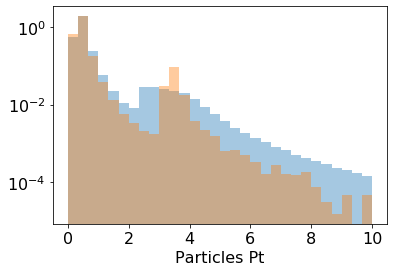

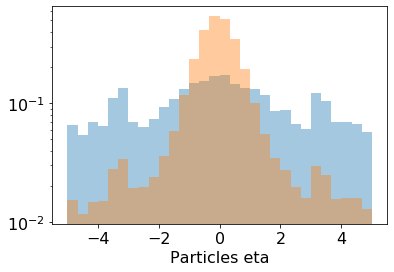

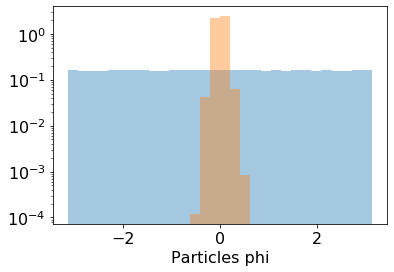

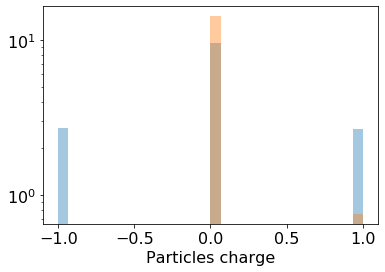

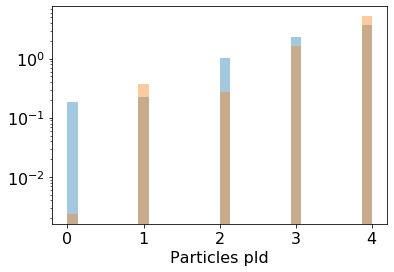

In [39]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=30, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=30, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
    plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [26]:
dataset.loadValidationSamples('SM')

Loading Wlnu (1000.0k)
Loading qcd (570.9k)
Loading Zll (886.8k)
Loading ttbar (994.9k)
SM Mix limiting stat. sample: qcd (0.57M)
SM validation weights
[('Wlnu', 0.99999834319526624413), ('qcd', 1.0), ('Zll', 0.12761873894588048826), ('ttbar', 0.0050933672635218982447)]


In [27]:
model.eval()
for n in dataset.valSamples.keys():
    dataset.loss[n] = np.zeros((0))
    
    dataset.charge(dataset.valSamples[n])
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

Ato4l: [#####]  100% - Tot. time: 0.1 s
leptoquark: [####################]  100% - Tot. time: 1.3 s
hToTauTau: [####################]  100% - Tot. time: 2.8 s
hChToTauNu: [####################]  100% - Tot. time: 1.7 s
Wlnu: [####################]  100% - Tot. time: 6.4 s
qcd: [####################]  100% - Tot. time: 3.4 s
Zll: [####################]  100% - Tot. time: 6.0 s
ttbar: [####################]  100% - Tot. time: 6.8 s


In [28]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

CumSum accuracy: 0.99999999999998940865


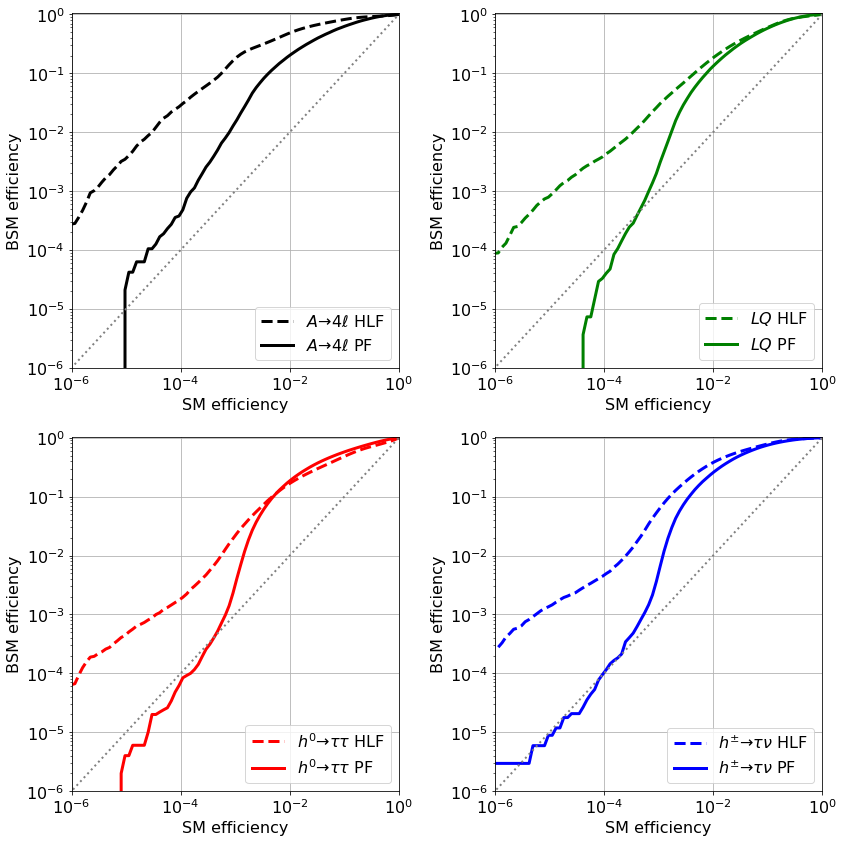

In [29]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [30]:
from sklearn.manifold import TSNE

In [47]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [48]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

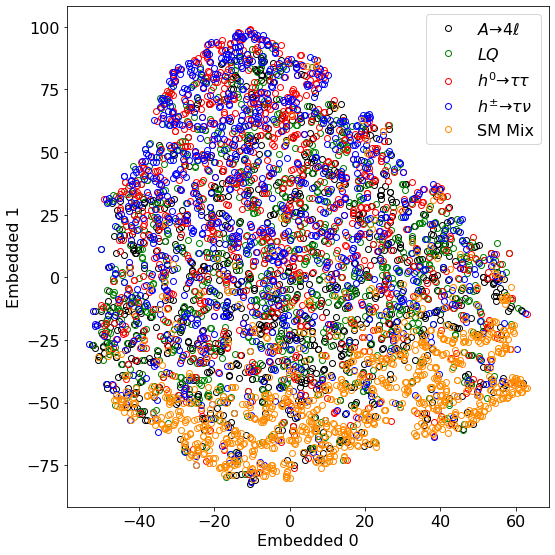

In [53]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()